In [1]:
from model import ToyNet, UNet
import torch
import numpy as np
import logging
from sklearn import datasets

#from pytorch_lightning import LightningDataModule
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import torch.nn as nn
from torch.distributions import Normal, Categorical, MixtureSameFamily
import torch.nn.functional as F

from tmp_utils import SDEProcess, plot_trajs
import warnings
warnings.filterwarnings("ignore")
#device = 'mps'
device = 'cuda:0'
import random
from src.PCF_with_empirical_measure import PCF_with_empirical_measure

In [2]:
def init_seed(seed):
    torch.cuda.manual_seed_all(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
init_seed(1)

In [3]:
def make_s_curve_data(n_samples, noise=0.05):
    data, _ = datasets.make_s_curve(n_samples=n_samples, noise=noise)
    data = data[:, [0, 2]] /1.5
    return torch.tensor(data.astype("float32"))

def plot_traj_2d(forward_traj, backward_traj):
    steps = forward_traj.shape[2]
    vis_steps = np.linspace(0, steps-1 ,5).astype('int')
    
    for t in vis_steps:
        plt.figure(figsize=(12,3))
        plt.subplot(1, 2, 1)
        data = forward_traj[:, :, t]
        plt.scatter(data[:, 0], data[:, 1], s=5, alpha=1.0)
        #scatter_plot = plt.scatter(x_q[:, 0], x_q[:, 1], s=5, alpha=0.5, label=r'', color='red')
        plt.axis('equal')
        plt.ylabel(f't={t}')
        plt.title('Forward')
        
        plt.subplot(1, 2, 2)
        data = backward_traj[:, :, t]        
        plt.scatter(data[:, 0], data[:, 1], s=5, alpha=1.0, color='r')
        #scatter_plot = plt.scatter(x_q[:, 0], x_q[:, 1], s=5, alpha=0.5, label=r'', color='red')
        plt.axis('equal')
        plt.title('Backward')
        plt.show()

def plot_x_gen(x_real, x_gen):
    plt.figure(figsize=(12,3))
    plt.subplot(1, 2, 1)
    
    plt.scatter(x_real[:, 0], x_real[:, 1], s=5, alpha=1.0)
    #scatter_plot = plt.scatter(x_q[:, 0], x_q[:, 1], s=5, alpha=0.5, label=r'', color='red')
    plt.axis('equal')
    #plt.ylabel(f't={t}')
    plt.title('Real')
        
    plt.subplot(1, 2, 2)
    plt.scatter(x_gen[:, 0], x_gen[:, 1], s=5, alpha=1.0, color='r')
    #scatter_plot = plt.scatter(x_q[:, 0], x_q[:, 1], s=5, alpha=0.5, label=r'', color='red')
    plt.axis('equal')
    plt.title('Gen')
    plt.show()

In [4]:
data= make_s_curve_data(n_samples=128)  


In [5]:
score_net = ToyNet(data_dim=2).to(device)
total_steps = 100
num_paths = 128
diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP", device=device)

In [6]:
x_data = make_s_curve_data(n_samples=num_paths)  
x_noise, traj_forward = diffusion.forward_sample(x_data)

x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 2]).to(device), score_net)

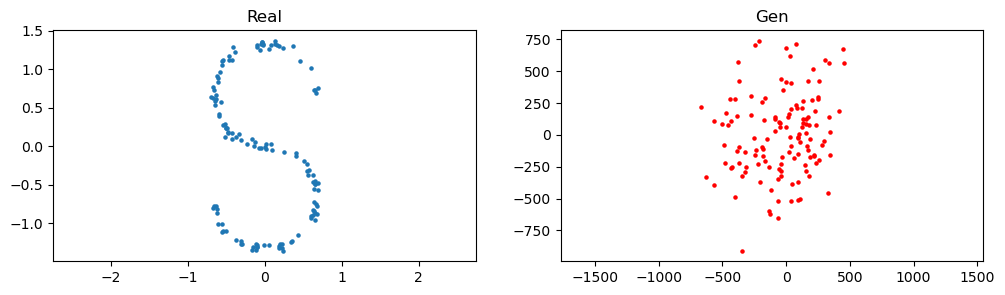

In [7]:
plot_x_gen(x_data, x_gen.cpu())

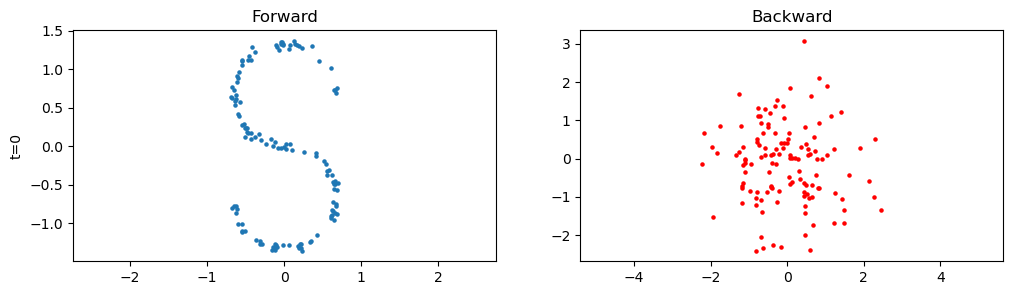

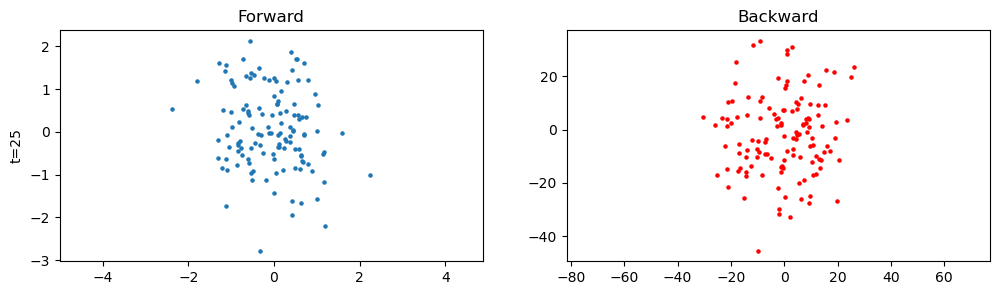

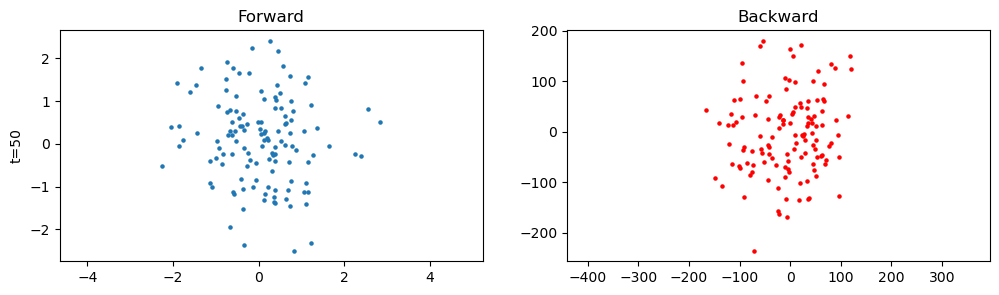

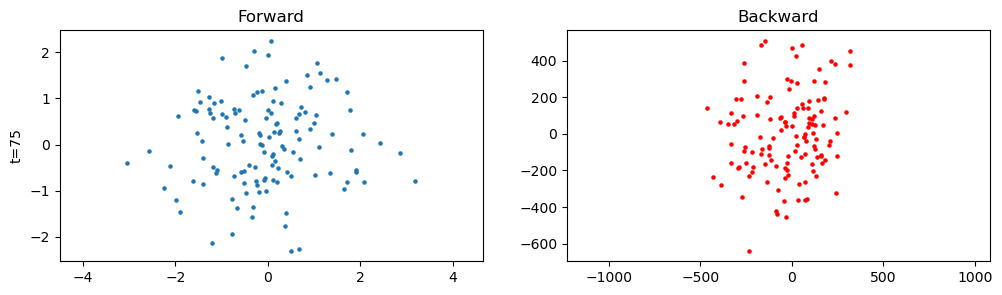

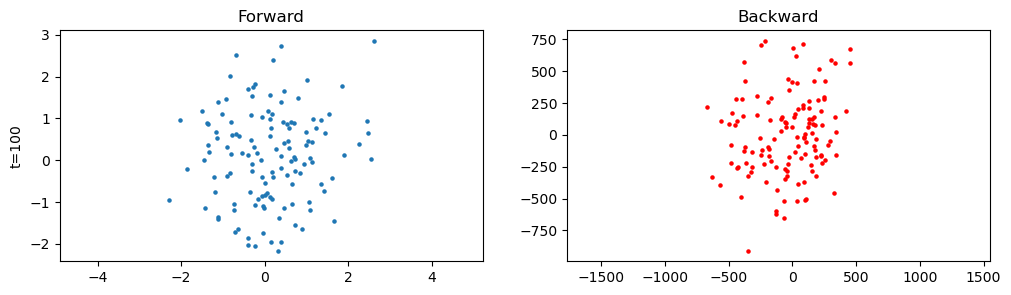

In [8]:
plot_traj_2d(traj_forward, traj_back.cpu())

In [9]:
def loss_function(x0, diffusion_process, score_net, t):
    #f_t is not involved in the score matching loss soe input zeros for the 1st argument.
    #
    _, g_t = diffusion_process.sde.drifts(torch.zeros_like(x0), t)
    
    # Eq 29 in Score based diffusion model (Yang Song 2021 ICLR)
    mean, std = diffusion_process.sde.perturbation_kernel(x0, t)
    z = torch.randn_like(x0)

    x_t = mean + std * z  # x_t is perturbed x_0
    pred_score = score_net(x_t, t)
    target = -z / std   # Since desired derivative of the given kernel is - (x_t - mean) / std^2
    loss = g_t**2 * F.mse_loss(pred_score, target, reduction="sum") / np.prod(x0.size())
    return loss

In [10]:
score_net = ToyNet(data_dim=2).to(device)
total_steps = 50
num_paths = 128
diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP", device=device)

pcf = PCF_with_empirical_measure(16, 10, 2, add_time=True)
pcf = pcf.to(device)

G_opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)
D_opt = torch.optim.Adam(pcf.parameters(), lr=1e-3)

Train the network with PCF distance and reconstrucion loss. Time dimension has been added the PCF network.

I am using min-max way to train both PCF network and score network.

Haven't test the combined loss with new backward sampling fucntion i.e. backward_sample_example that can been seen in latter block. will do later.

0 tensor(16.6832, device='cuda:0', grad_fn=<DivBackward0>)


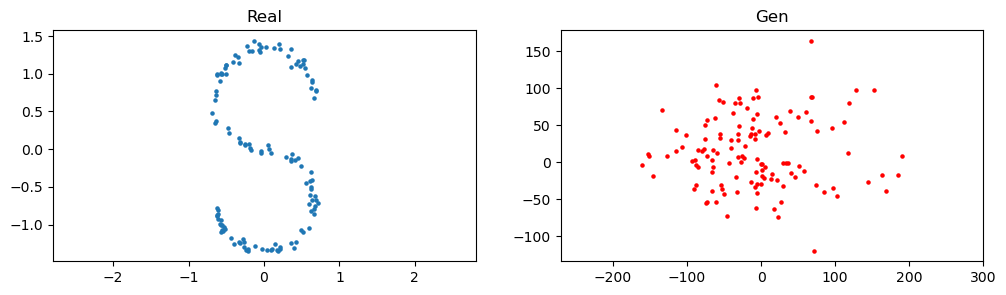

1000 tensor(0.7480, device='cuda:0', grad_fn=<DivBackward0>)


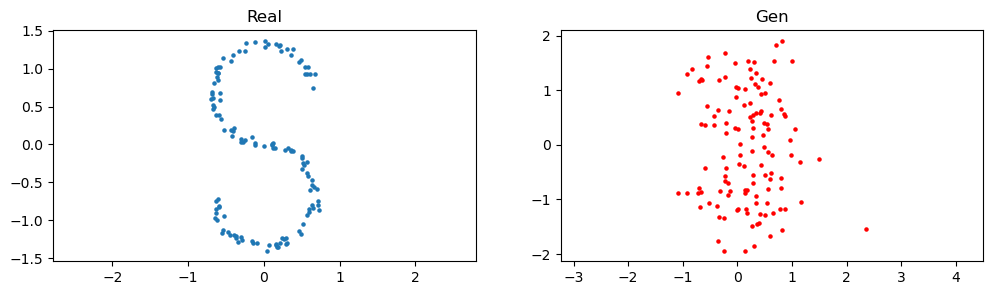

2000 tensor(0.0847, device='cuda:0', grad_fn=<DivBackward0>)


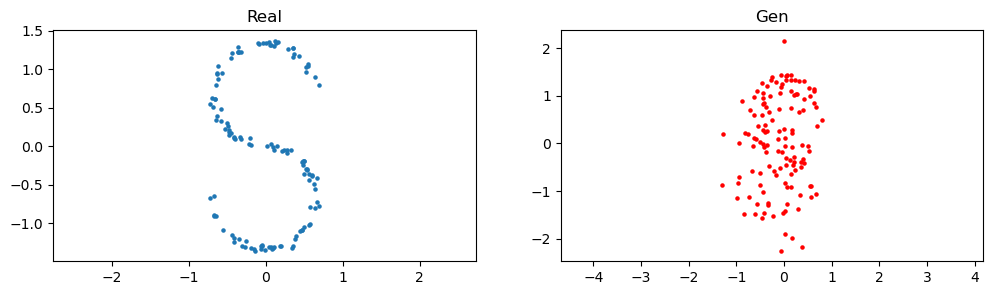

3000 tensor(0.1763, device='cuda:0', grad_fn=<DivBackward0>)


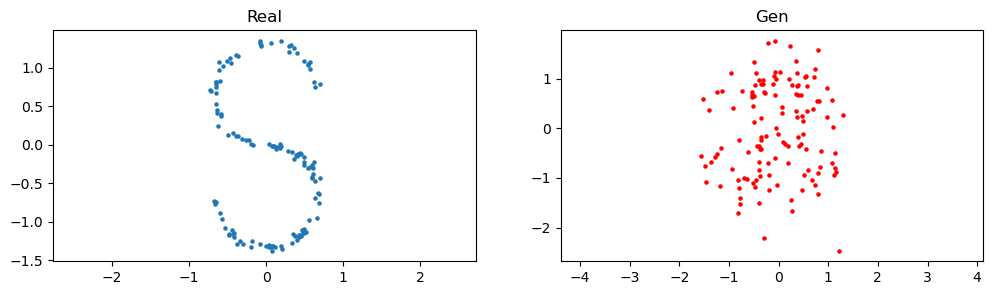

4000 tensor(72.6769, device='cuda:0', grad_fn=<DivBackward0>)


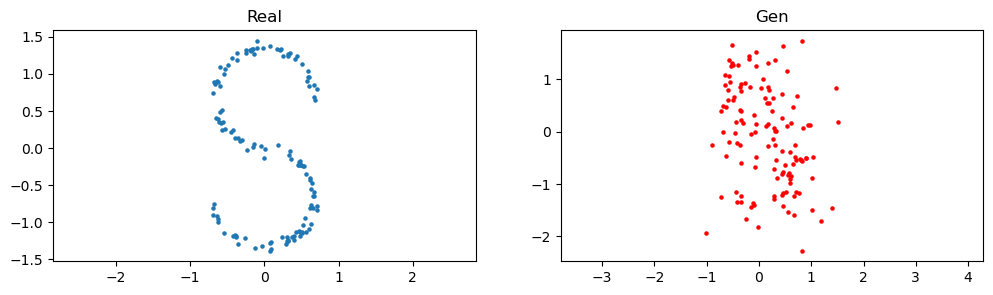

5000 tensor(0.3171, device='cuda:0', grad_fn=<DivBackward0>)


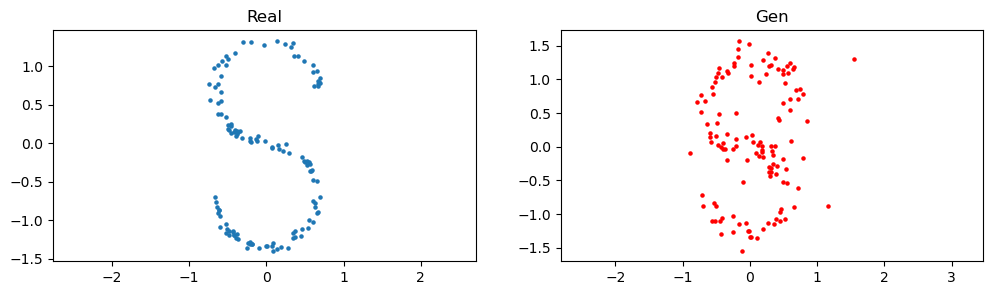

6000 tensor(0.2836, device='cuda:0', grad_fn=<DivBackward0>)


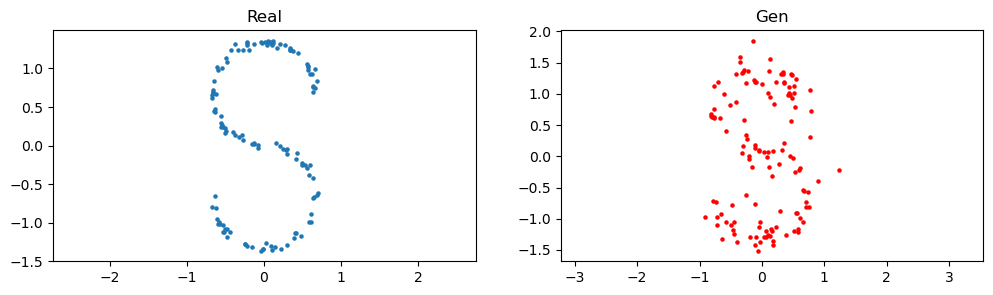

7000 tensor(1.8817, device='cuda:0', grad_fn=<DivBackward0>)


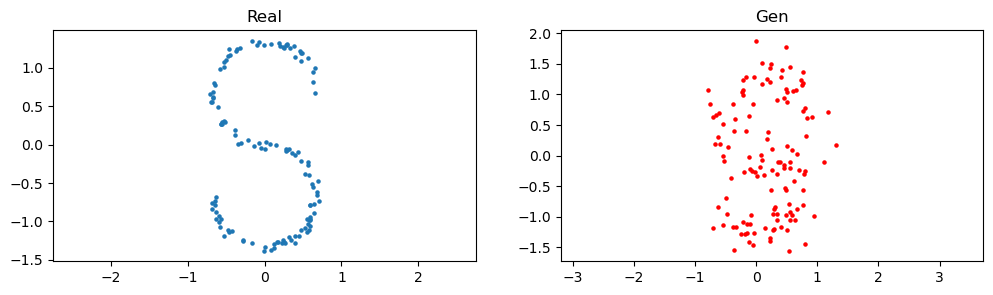

8000 tensor(0.7292, device='cuda:0', grad_fn=<DivBackward0>)


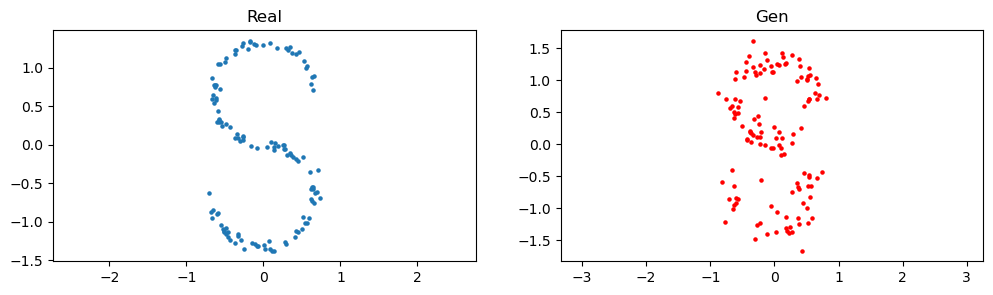

9000 tensor(0.6894, device='cuda:0', grad_fn=<DivBackward0>)


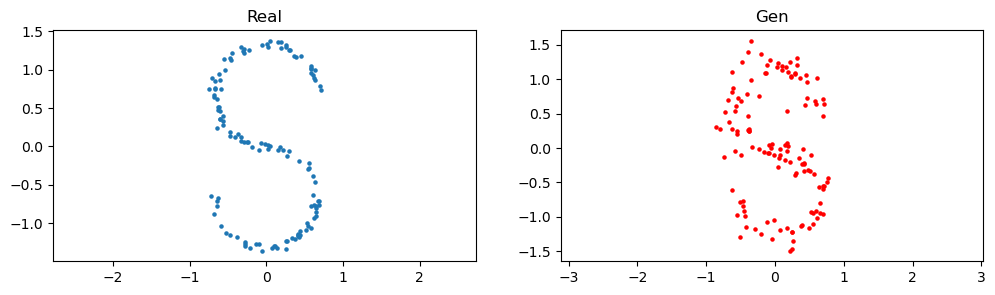

10000 tensor(1.8635, device='cuda:0', grad_fn=<DivBackward0>)


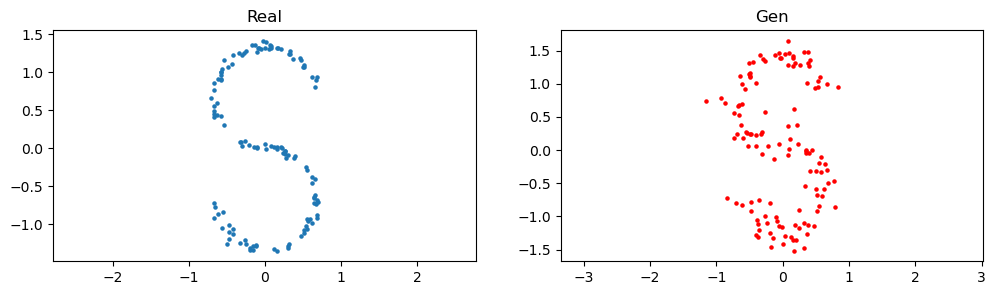

11000 tensor(0.0907, device='cuda:0', grad_fn=<DivBackward0>)


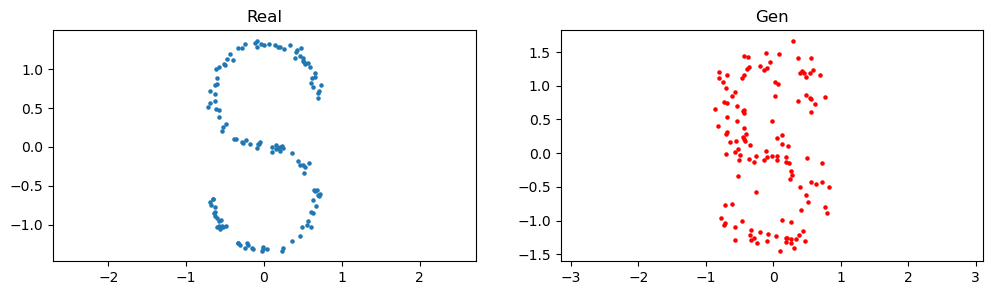

12000 tensor(0.2347, device='cuda:0', grad_fn=<DivBackward0>)


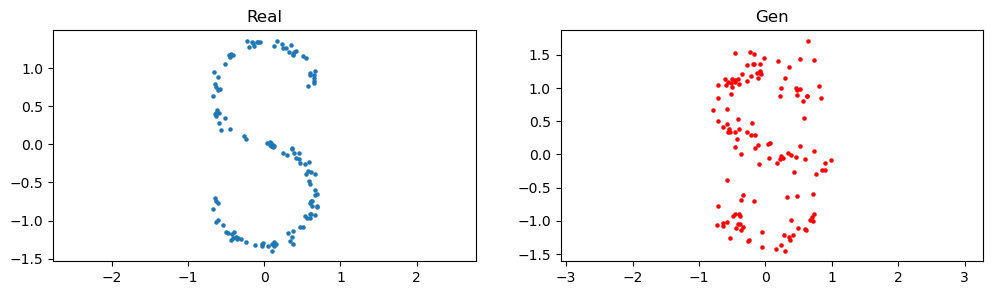

13000 tensor(0.5889, device='cuda:0', grad_fn=<DivBackward0>)


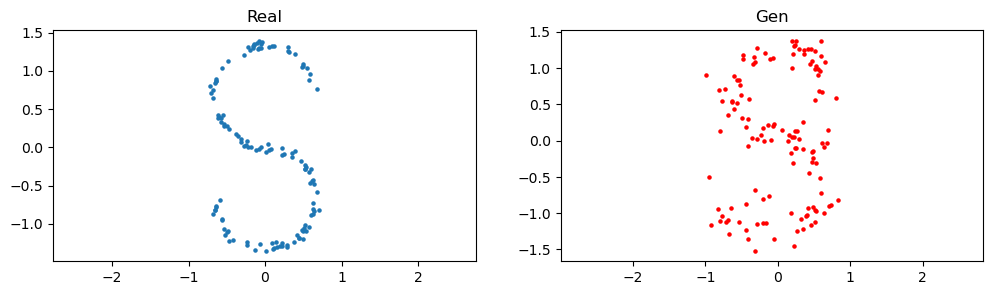

14000 tensor(3.1019, device='cuda:0', grad_fn=<DivBackward0>)


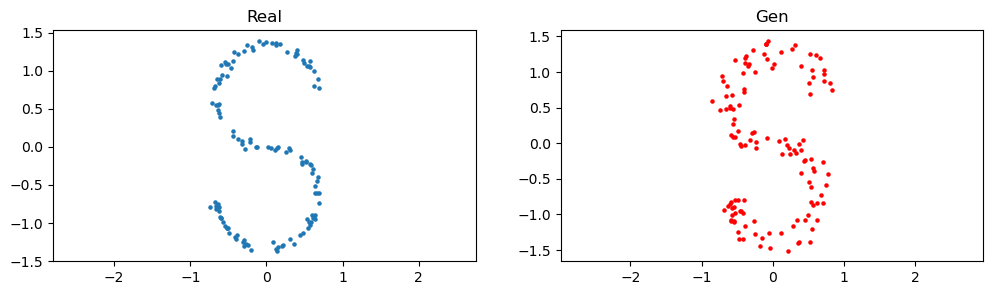

15000 tensor(3.0563, device='cuda:0', grad_fn=<DivBackward0>)


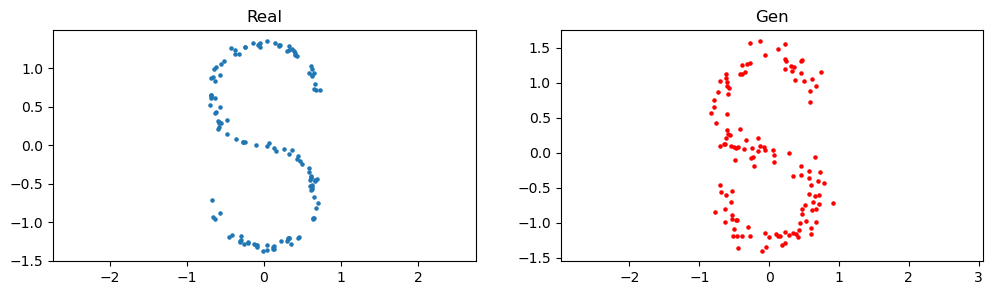

16000 tensor(0.0434, device='cuda:0', grad_fn=<DivBackward0>)


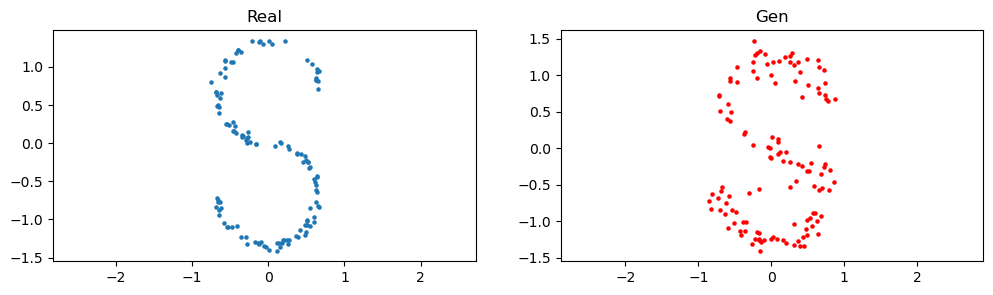

17000 tensor(1.7535, device='cuda:0', grad_fn=<DivBackward0>)


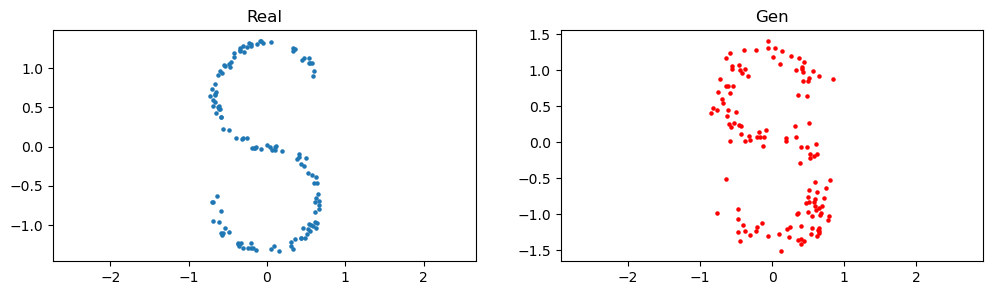

18000 tensor(3.8930, device='cuda:0', grad_fn=<DivBackward0>)


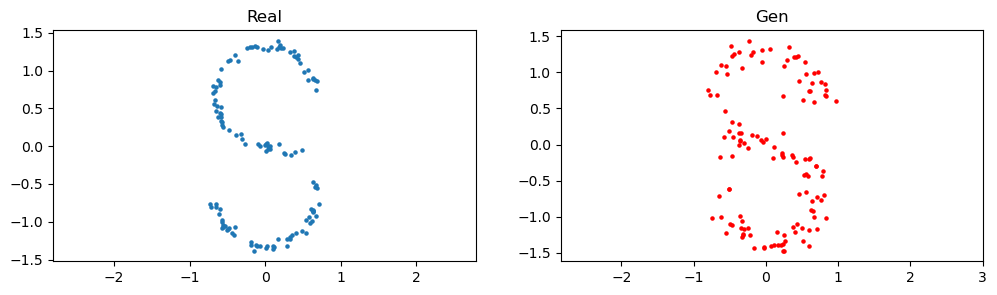

19000 tensor(5.2979, device='cuda:0', grad_fn=<DivBackward0>)


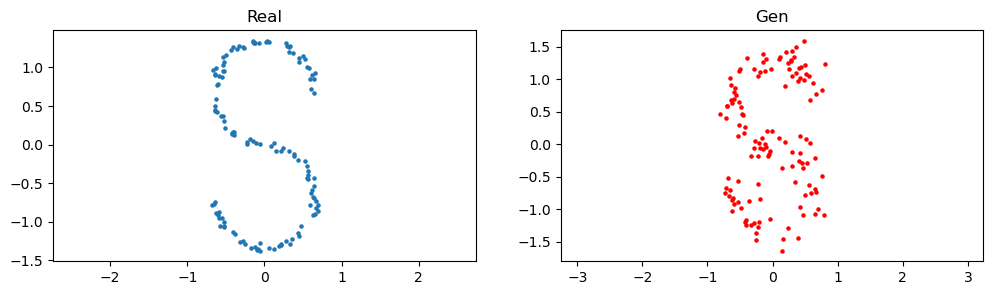

20000 tensor(0.3902, device='cuda:0', grad_fn=<DivBackward0>)


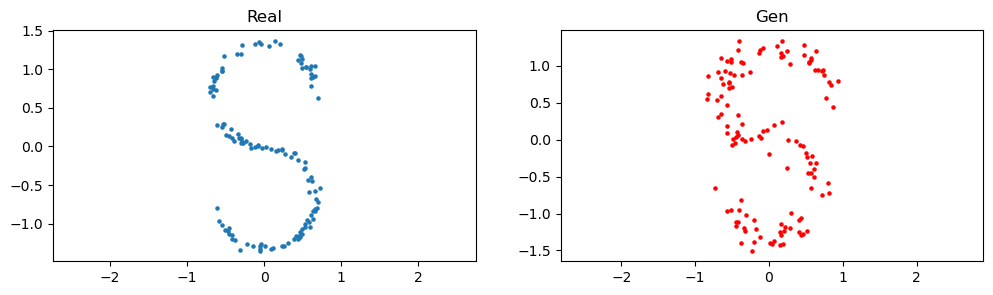

21000 tensor(0.0284, device='cuda:0', grad_fn=<DivBackward0>)


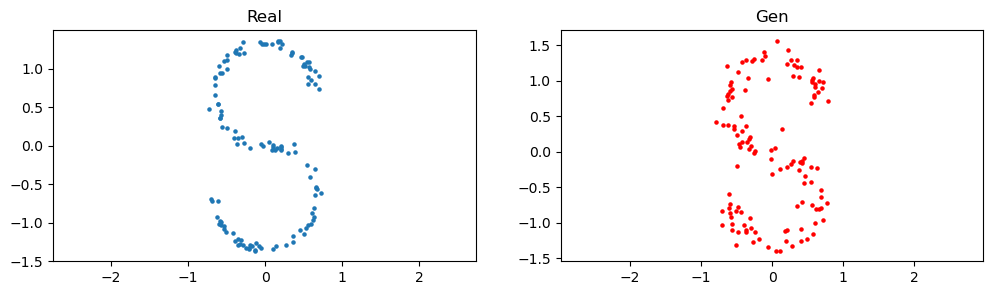

22000 tensor(0.5191, device='cuda:0', grad_fn=<DivBackward0>)


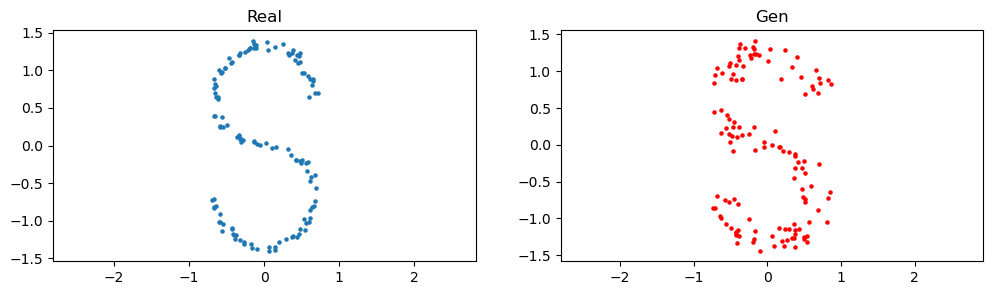

23000 tensor(0.0479, device='cuda:0', grad_fn=<DivBackward0>)


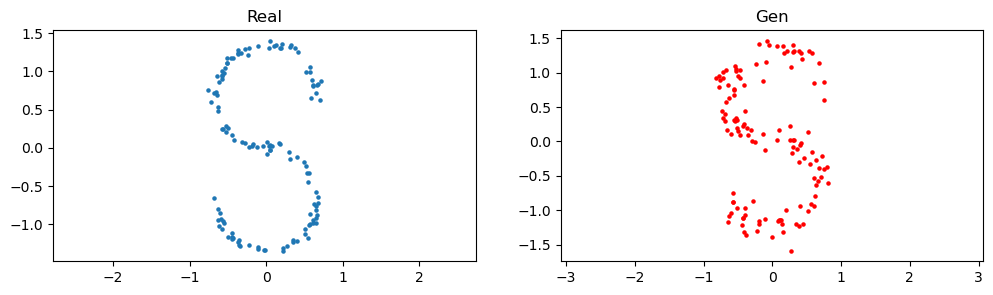

24000 tensor(0.9660, device='cuda:0', grad_fn=<DivBackward0>)


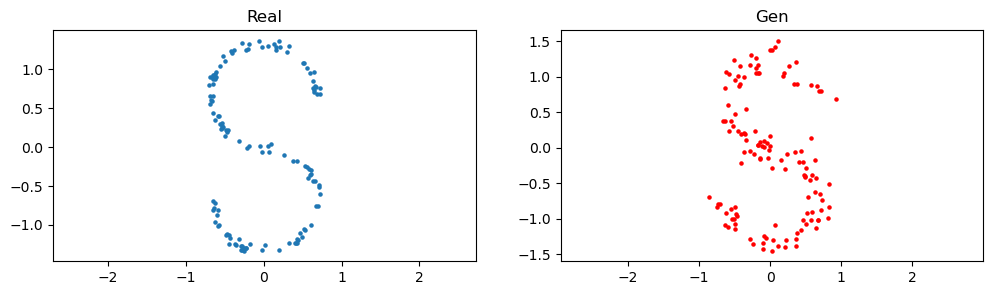

25000 tensor(1.3619, device='cuda:0', grad_fn=<DivBackward0>)


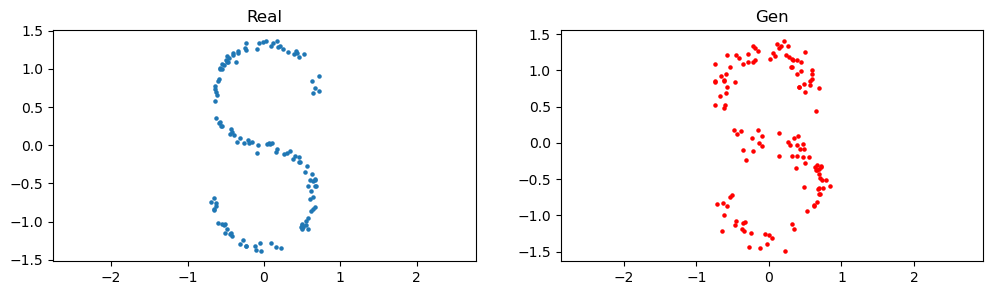

26000 tensor(0.0566, device='cuda:0', grad_fn=<DivBackward0>)


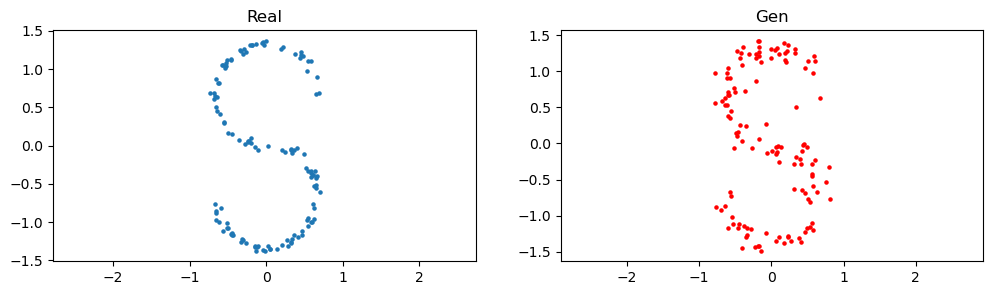

27000 tensor(0.0394, device='cuda:0', grad_fn=<DivBackward0>)


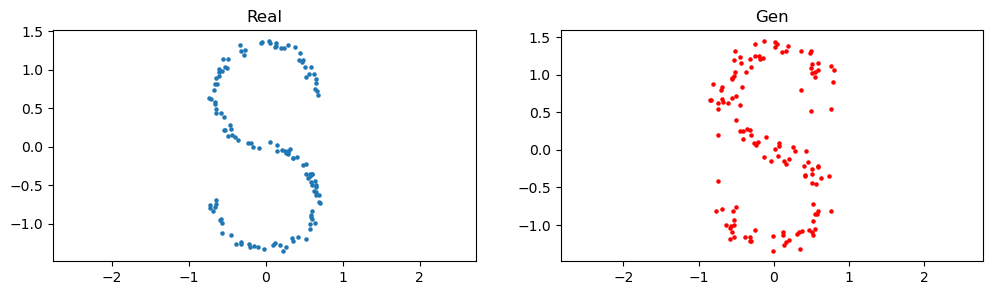

28000 tensor(1.8066, device='cuda:0', grad_fn=<DivBackward0>)


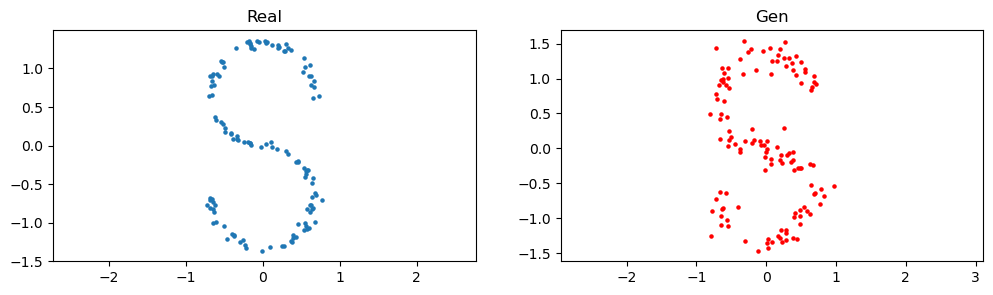

29000 tensor(22.0405, device='cuda:0', grad_fn=<DivBackward0>)


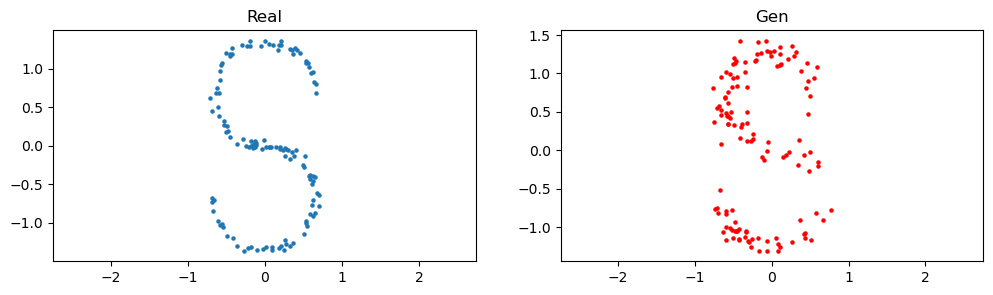

30000 tensor(0.0233, device='cuda:0', grad_fn=<DivBackward0>)


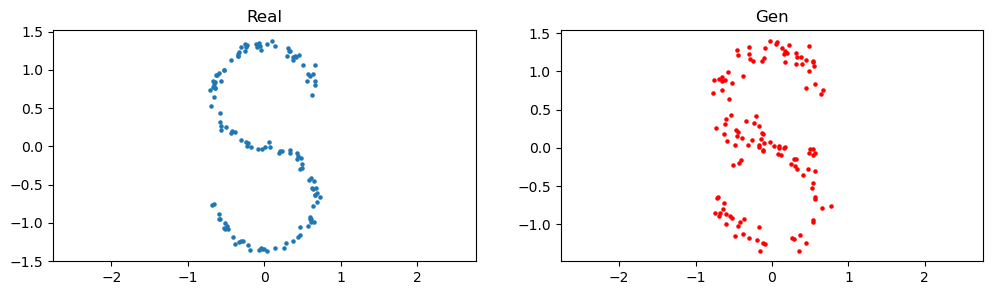

31000 tensor(2.4372, device='cuda:0', grad_fn=<DivBackward0>)


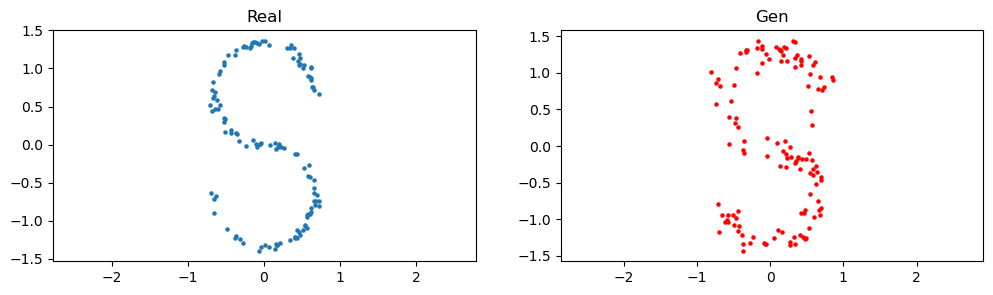

32000 tensor(63.9129, device='cuda:0', grad_fn=<DivBackward0>)


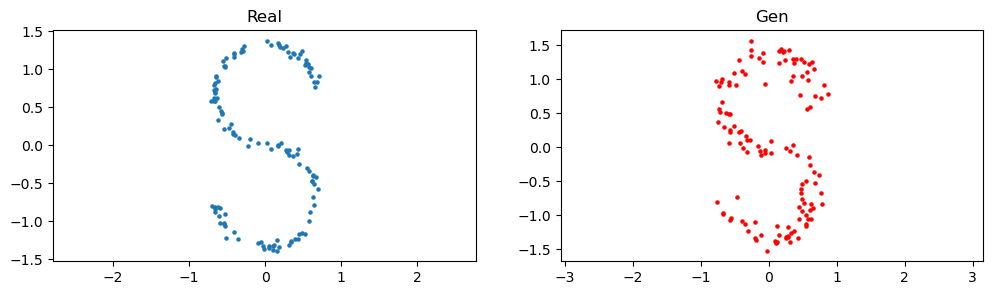

33000 tensor(0.1337, device='cuda:0', grad_fn=<DivBackward0>)


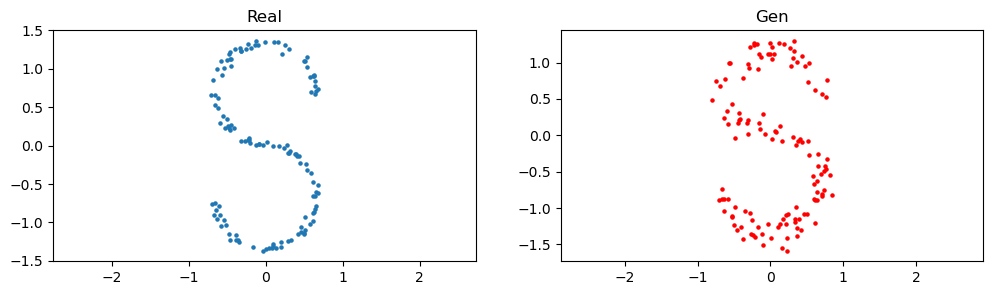

34000 tensor(0.0835, device='cuda:0', grad_fn=<DivBackward0>)


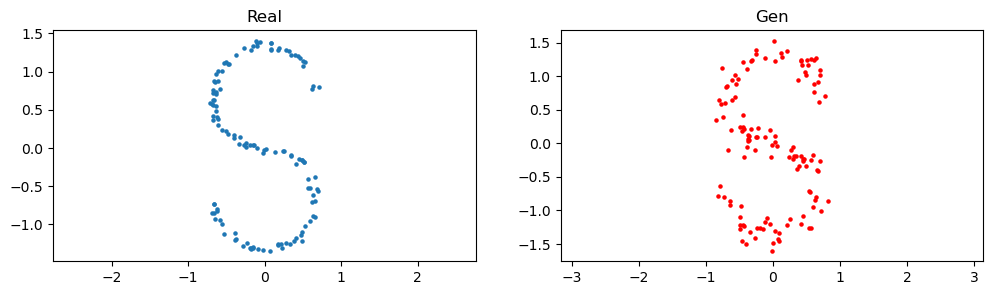

35000 tensor(6.6018, device='cuda:0', grad_fn=<DivBackward0>)


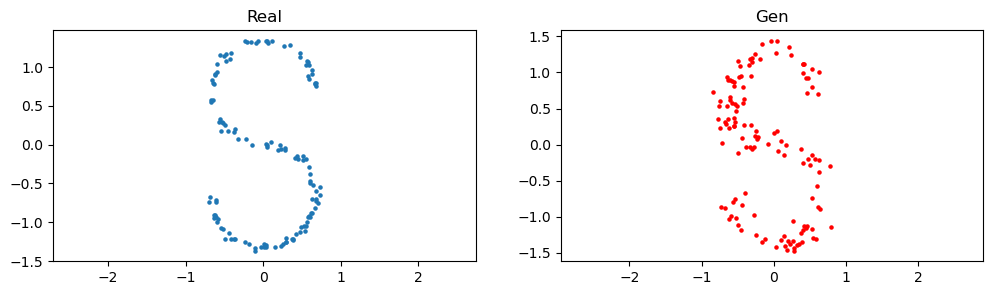

36000 tensor(4.1087, device='cuda:0', grad_fn=<DivBackward0>)


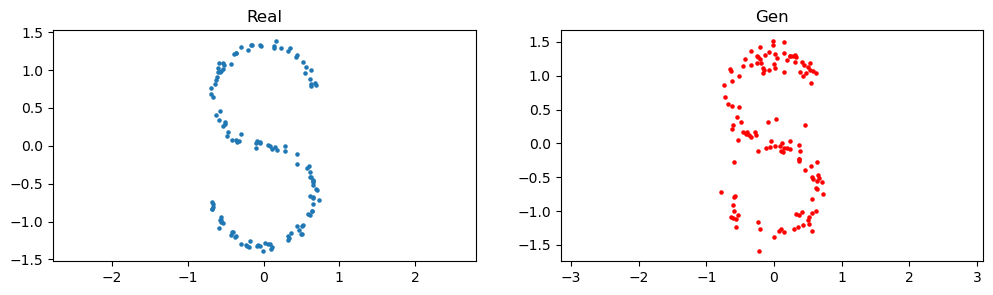

37000 tensor(2.9011, device='cuda:0', grad_fn=<DivBackward0>)


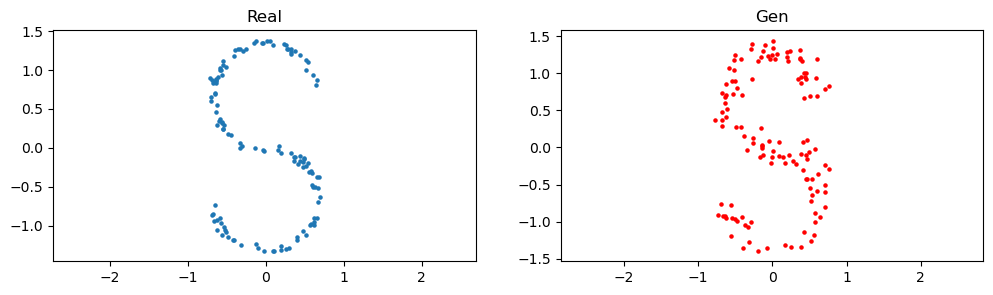

38000 tensor(0.0646, device='cuda:0', grad_fn=<DivBackward0>)


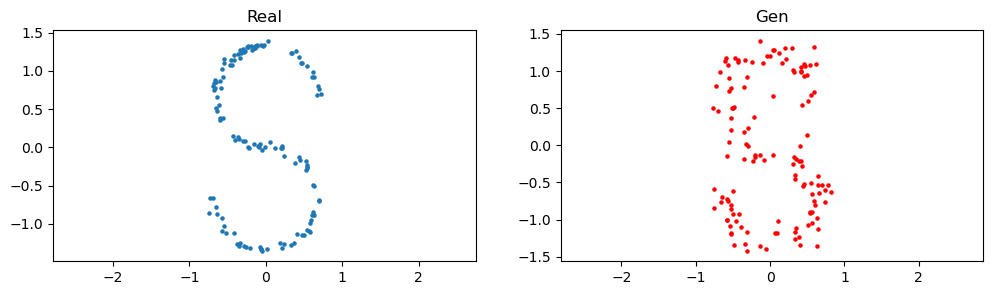

39000 tensor(11.3344, device='cuda:0', grad_fn=<DivBackward0>)


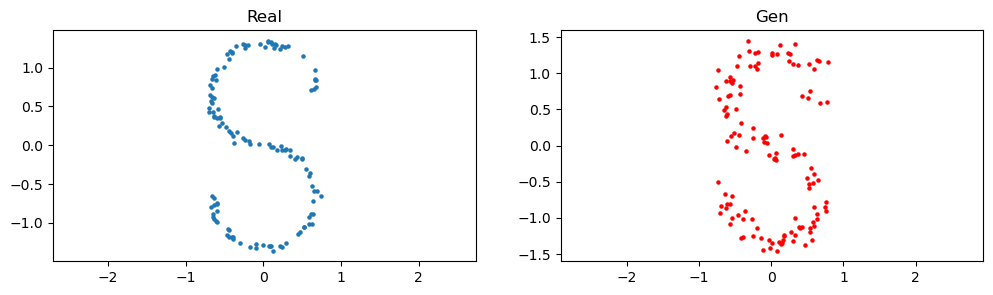

40000 tensor(0.0412, device='cuda:0', grad_fn=<DivBackward0>)


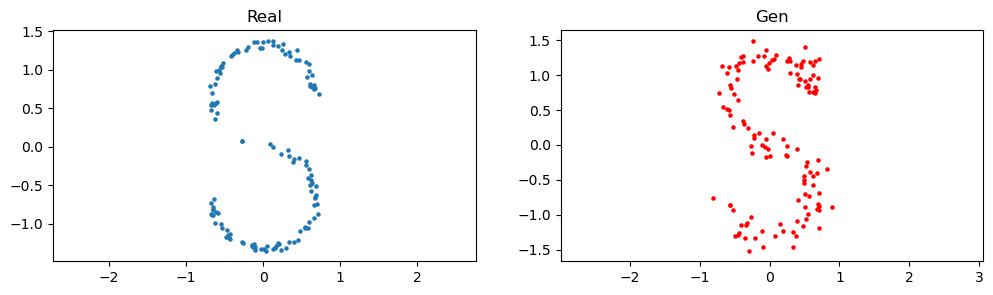

41000 tensor(5.1330, device='cuda:0', grad_fn=<DivBackward0>)


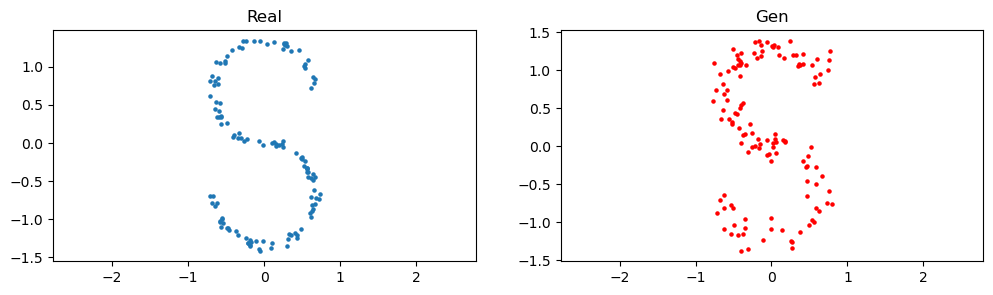

42000 tensor(0.0504, device='cuda:0', grad_fn=<DivBackward0>)


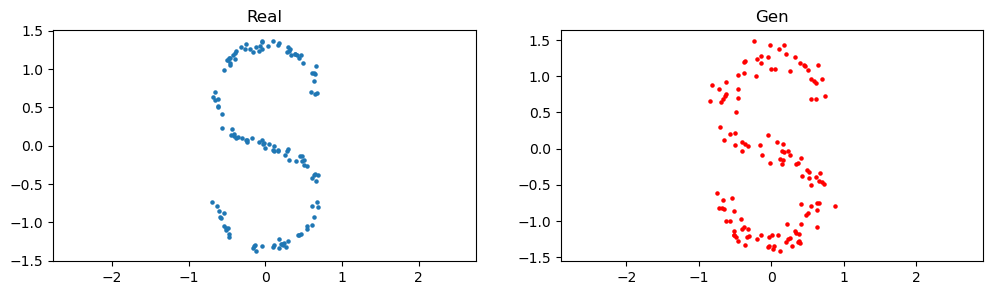

43000 tensor(0.0278, device='cuda:0', grad_fn=<DivBackward0>)


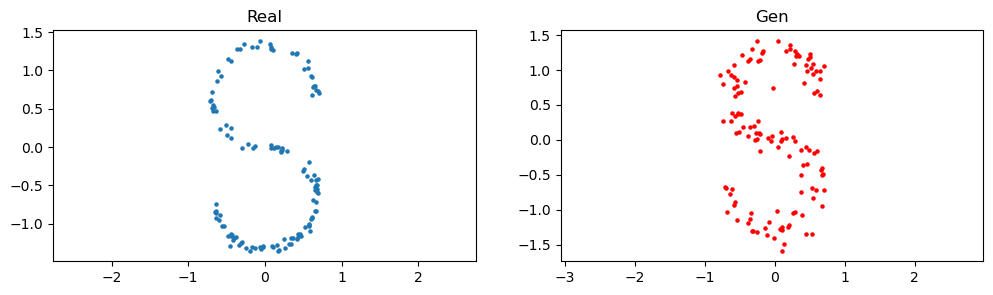

44000 tensor(0.0442, device='cuda:0', grad_fn=<DivBackward0>)


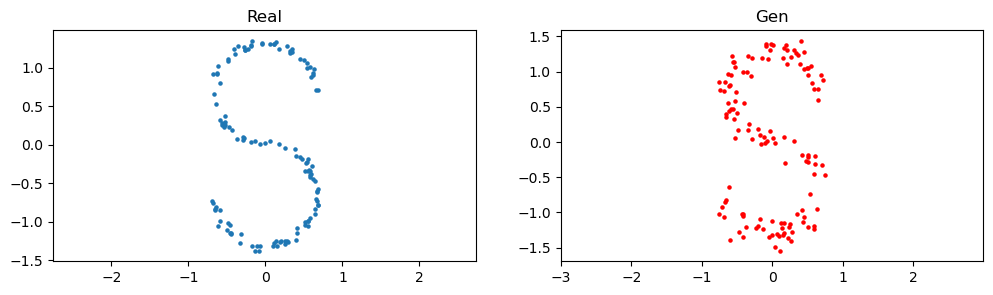

45000 tensor(0.0571, device='cuda:0', grad_fn=<DivBackward0>)


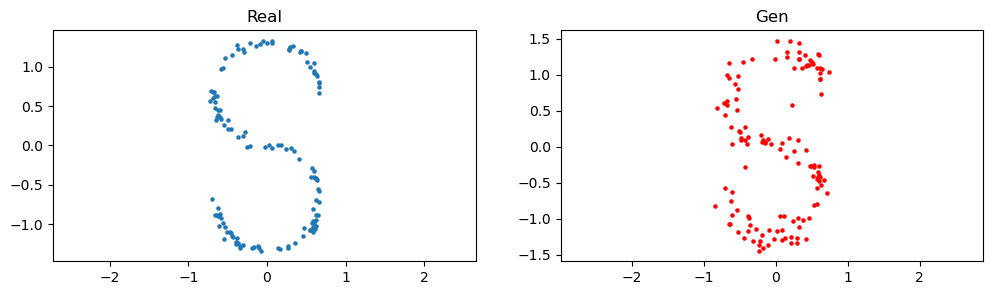

46000 tensor(0.0530, device='cuda:0', grad_fn=<DivBackward0>)


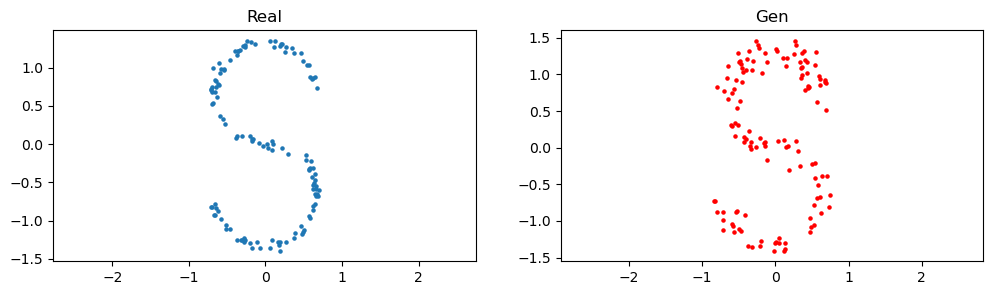

47000 tensor(0.2256, device='cuda:0', grad_fn=<DivBackward0>)


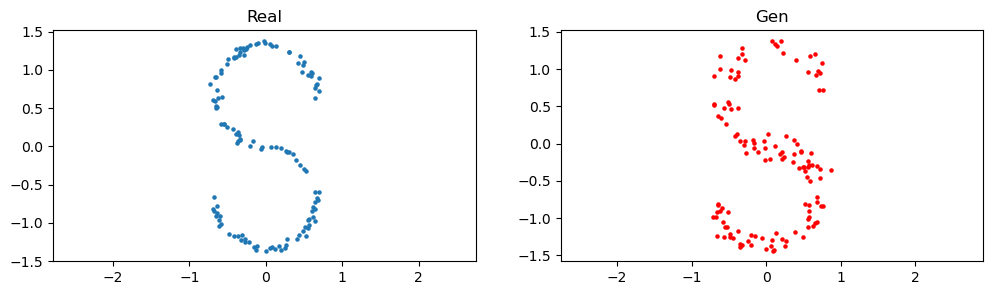

48000 tensor(1.2945, device='cuda:0', grad_fn=<DivBackward0>)


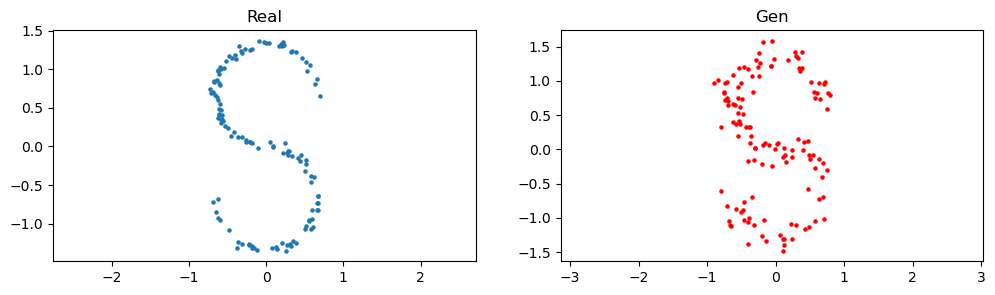

49000 tensor(0.8907, device='cuda:0', grad_fn=<DivBackward0>)


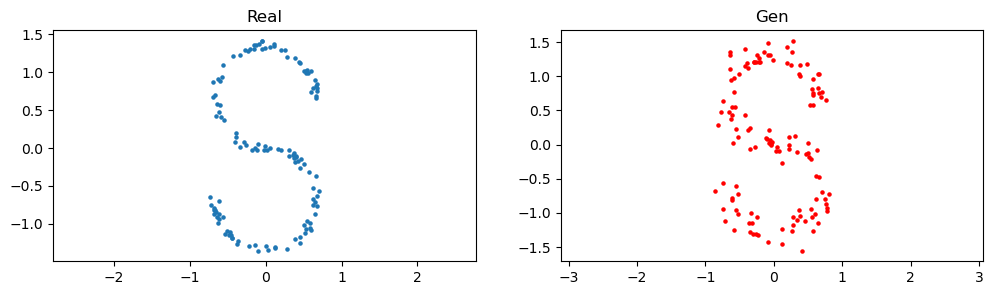

50000 tensor(15.0099, device='cuda:0', grad_fn=<DivBackward0>)


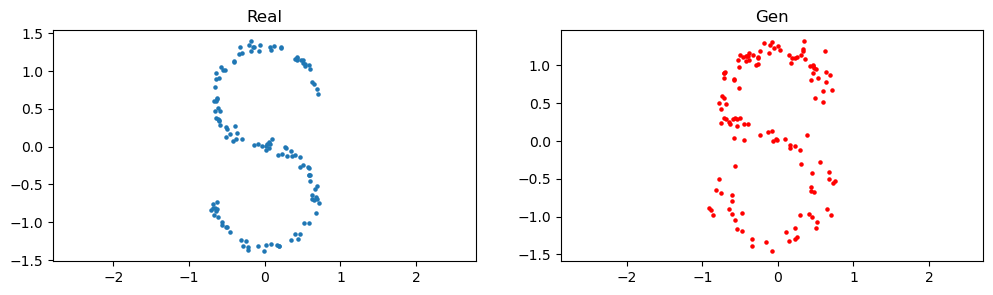

In [11]:
num_epochs = 50001
opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)

for i in range(num_epochs):
    # Forward process to generate time series
    opt.zero_grad()
    x_data = make_s_curve_data(n_samples=num_paths).to(device)  
    t = np.random.randint(1, total_steps + 1)
    loss = loss_function(x_data.view(-1 ,x_data.shape[1]), diffusion, score_net, t)
    loss.backward()
    opt.step()
    
    
    if i % 1000 == 0:
        print(i, loss)
        x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 2]).to(device), score_net)
        plot_x_gen(x_data.cpu(), x_gen.detach().cpu())